In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
tf.__version__
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
for dirname, _, fname in os.walk('../input'):
    print(dirname, '...........', len(os.listdir(dirname)))

../input ........... 1
../input/mask-datasets-v1 ........... 1
../input/mask-datasets-v1/Mask_Datasets ........... 2
../input/mask-datasets-v1/Mask_Datasets/Train ........... 2
../input/mask-datasets-v1/Mask_Datasets/Train/Mask ........... 350
../input/mask-datasets-v1/Mask_Datasets/Train/No_mask ........... 400
../input/mask-datasets-v1/Mask_Datasets/Validation ........... 2
../input/mask-datasets-v1/Mask_Datasets/Validation/Mask ........... 150
../input/mask-datasets-v1/Mask_Datasets/Validation/No_mask ........... 200


In [6]:
image_size = 150
batch_size = 32

train_dir = '../input/mask-datasets-v1/Mask_Datasets/Train'
valid_dir = '../input/mask-datasets-v1/Mask_Datasets/Validation'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    shear_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='binary'
    #class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='binary'
    #class_mode='categorical'
)

Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)       

In [12]:
history = model.fit(
    train_generator,
    epochs = 10,
    verbose=1,
    validation_data = valid_generator
)

Train for 24 steps, validate for 11 steps
Epoch 1/10
24/24 [==============================] - 32s 1s/step - loss: 0.6835 - accuracy: 0.5533 - val_loss: 0.6248 - val_accuracy: 0.7429
Epoch 2/10
24/24 [==============================] - 31s 1s/step - loss: 0.4957 - accuracy: 0.7520 - val_loss: 0.3402 - val_accuracy: 0.8771
Epoch 3/10
24/24 [==============================] - 31s 1s/step - loss: 0.3567 - accuracy: 0.8427 - val_loss: 0.3872 - val_accuracy: 0.8686
Epoch 4/10
24/24 [==============================] - 32s 1s/step - loss: 0.4147 - accuracy: 0.8227 - val_loss: 0.3429 - val_accuracy: 0.9286
Epoch 5/10
24/24 [==============================] - 31s 1s/step - loss: 0.3110 - accuracy: 0.8707 - val_loss: 0.2265 - val_accuracy: 0.9286
Epoch 6/10
24/24 [==============================] - 32s 1s/step - loss: 0.2744 - accuracy: 0.9013 - val_loss: 0.3964 - val_accuracy: 0.8143
Epoch 7/10
24/24 [==============================] - 31s 1s/step - loss: 0.2987 - accuracy: 0.8907 - val_loss: 0.1612 -

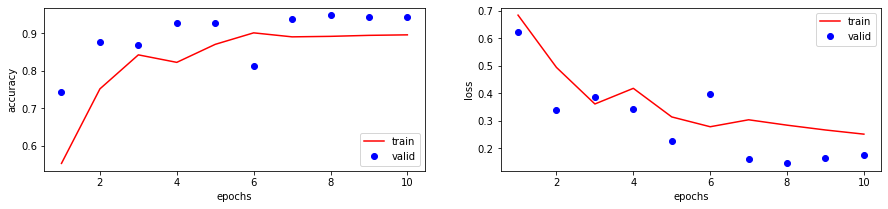

In [13]:
model.save('model.h5')

def plotting():
    epochs = np.arange(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.figure(figsize=(15,3))
    plt.subplot(121)
    plt.plot(epochs, train_acc, 'r', label='train' )
    plt.plot(epochs, val_acc, 'bo', label='valid')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.subplot(122)
    plt.plot(epochs, train_loss, 'r', label='train')
    plt.plot(epochs, val_loss, 'bo', label='valid')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
plotting()

In [15]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labelssoftmax.txt', 'w') as f:
  f.write(labels)

{'Mask': 0, 'No_mask': 1}


In [16]:
!ls

__notebook_source__.ipynb  labelssoftmax.txt  model.h5


In [17]:
#saved_model_dir = 'model'
#tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('modelsoftmax30epoch.tflite', 'wb') as f:
  f.write(tflite_model)

In [18]:
!ls

__notebook_source__.ipynb  model.h5
labelssoftmax.txt	   modelsoftmax30epoch.tflite
